In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap


from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

shap.initjs()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'Avenir'

In [2]:
# import dataset
# Dataset: https://archive.ics.uci.edu/ml/datasets/Abalone

data = pd.read_csv(
    "abalone.csv",
    names=[
        "sex",
        "length",
        "diameter",
        "height",
        "whole weight",
        "shucked weight",
        "viscera weight",
        "shell weight",
        "rings",
    ],
)

print(len(data))
data.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


<Axes: xlabel='whole weight', ylabel='rings'>

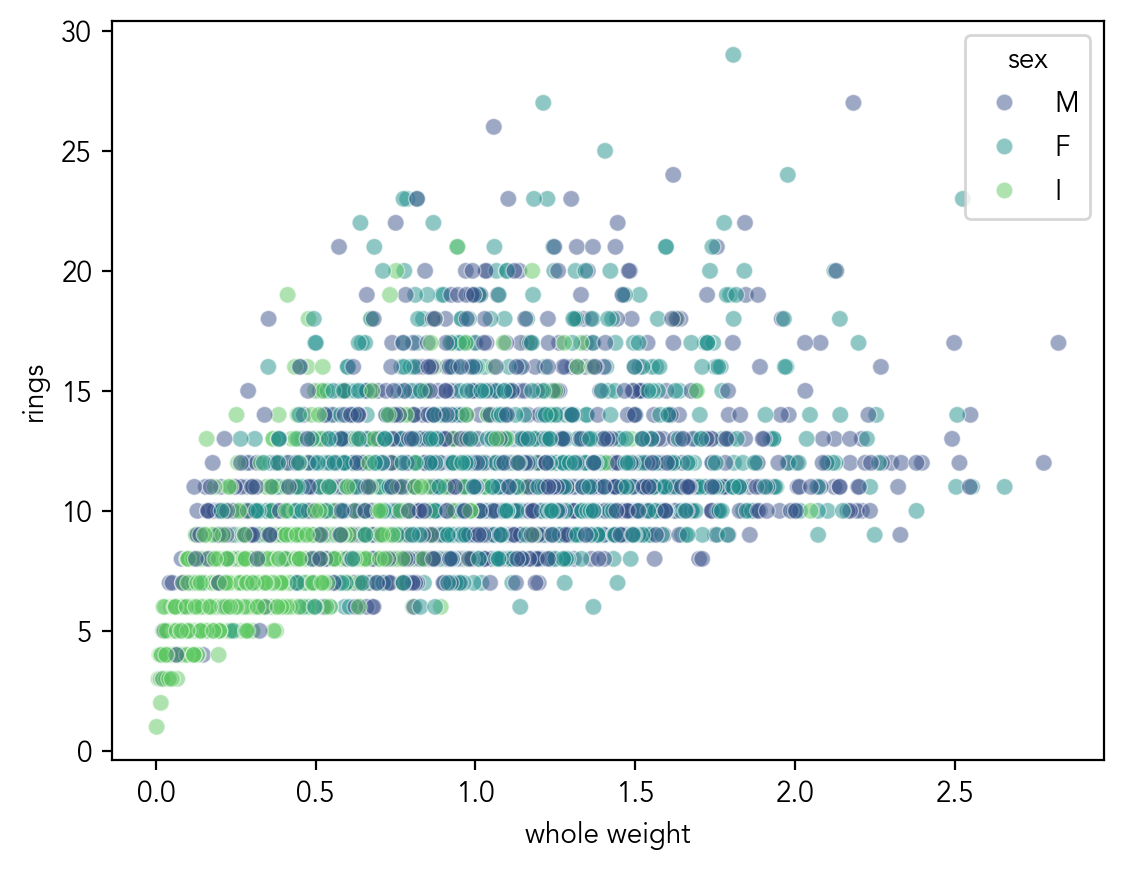

In [3]:
# Plot 1: Whole Weight

sns.scatterplot(data=data, x='whole weight', y='rings', alpha=0.5, hue='sex', palette='viridis')


<Axes: xlabel='sex', ylabel='rings'>

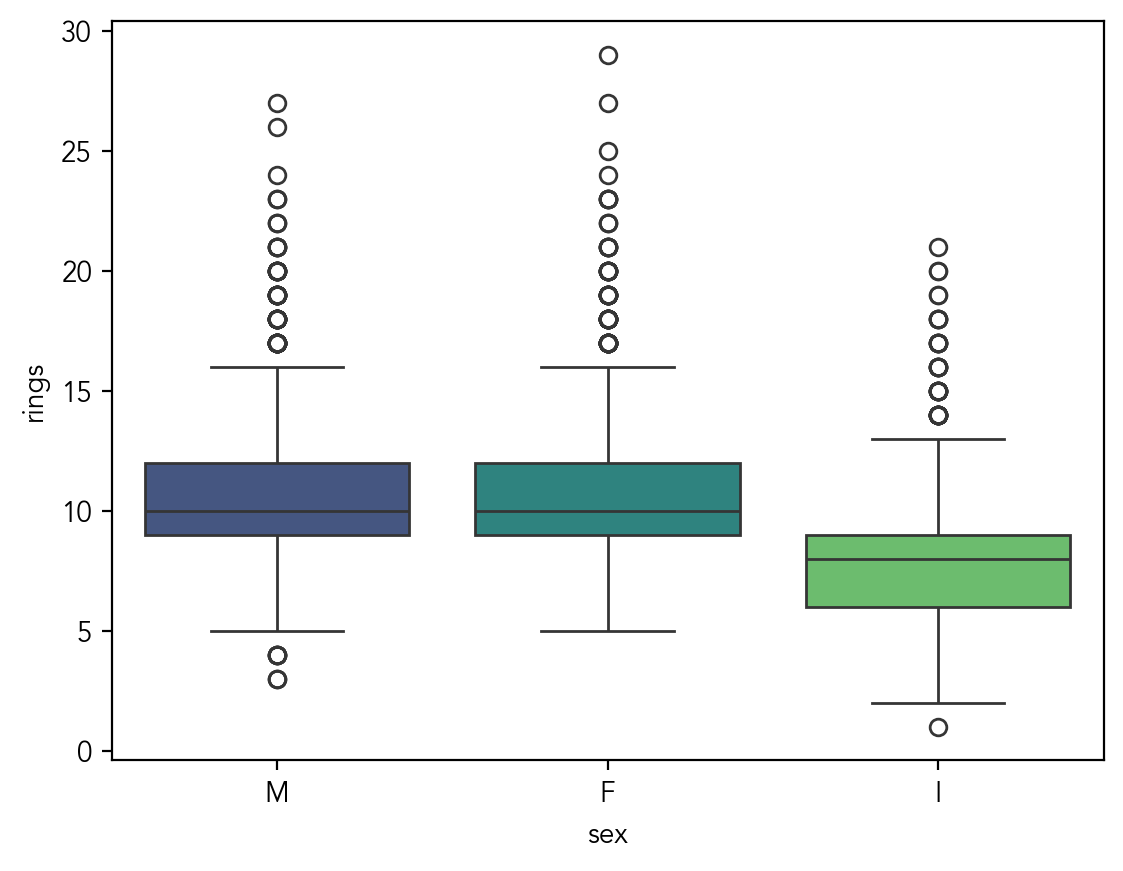

In [4]:
# Plot boxplots for the whole weight by sex

sns.boxplot(data = data, y = 'rings', x = 'sex', hue = 'sex', palette = 'viridis')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole weight    4177 non-null   float64
 5   shucked weight  4177 non-null   float64
 6   viscera weight  4177 non-null   float64
 7   shell weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


<Axes: >

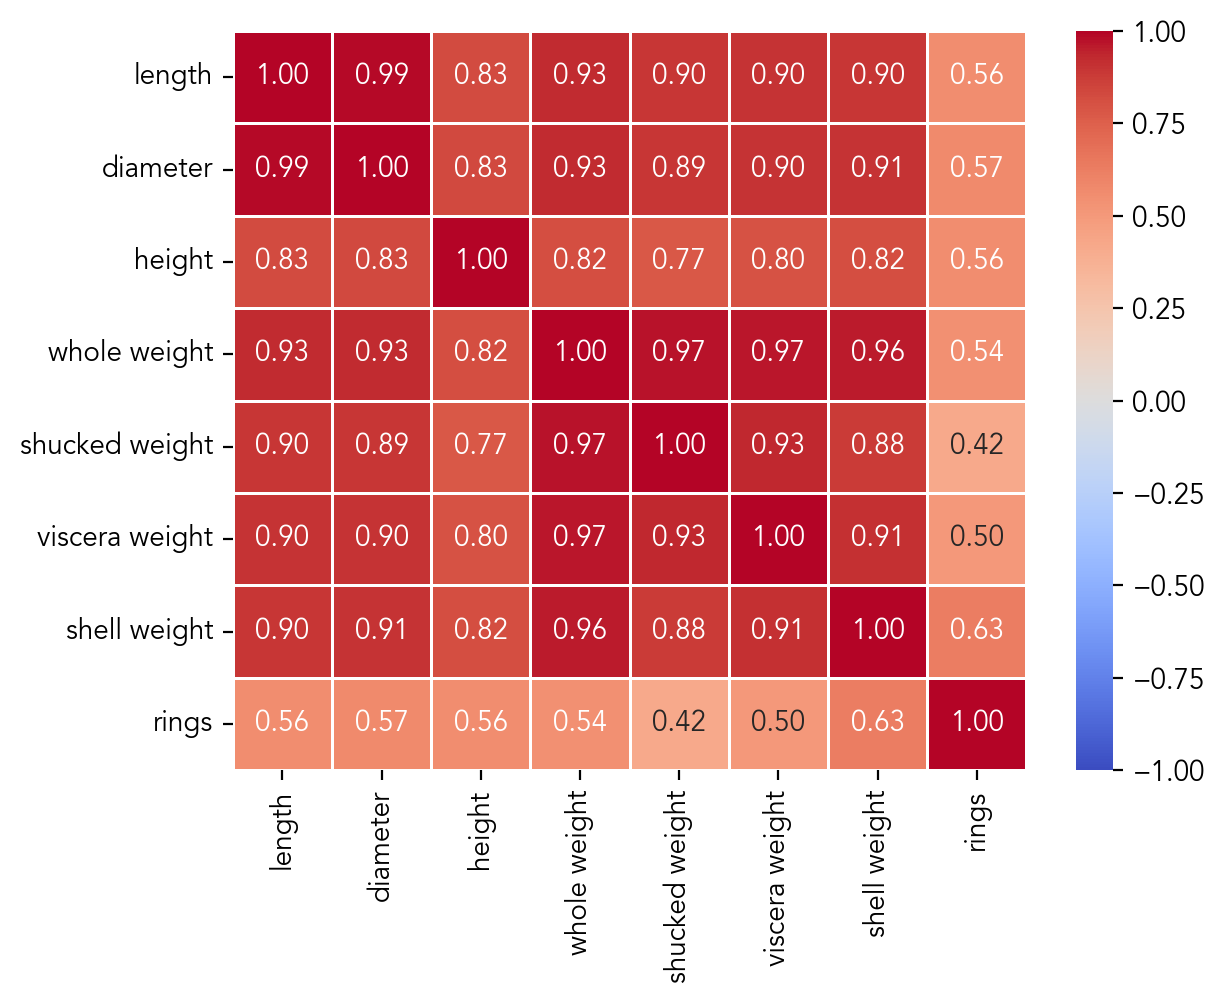

In [6]:
# Correlation matrix (excluding 'sex' column)

corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, center=0, vmin=-1, vmax=1)


In [7]:
# One-hot encoding for 'sex' column

data = pd.get_dummies(data=data, columns=['sex'], drop_first = False)


In [8]:
data.head()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,sex_F,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,True,False


In [9]:
# Split the dataset into X and y

X = data.drop('rings', axis =1)
y = data['rings']
X.shape, y.shape

((4177, 10), (4177,))

In [10]:
# Modeling with XGBoost

model = XGBRegressor(n_estimators = 100, random_state = 2024)
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

In [11]:
# Get predictions
y_pred = model.predict(X)

<Axes: xlabel='rings'>

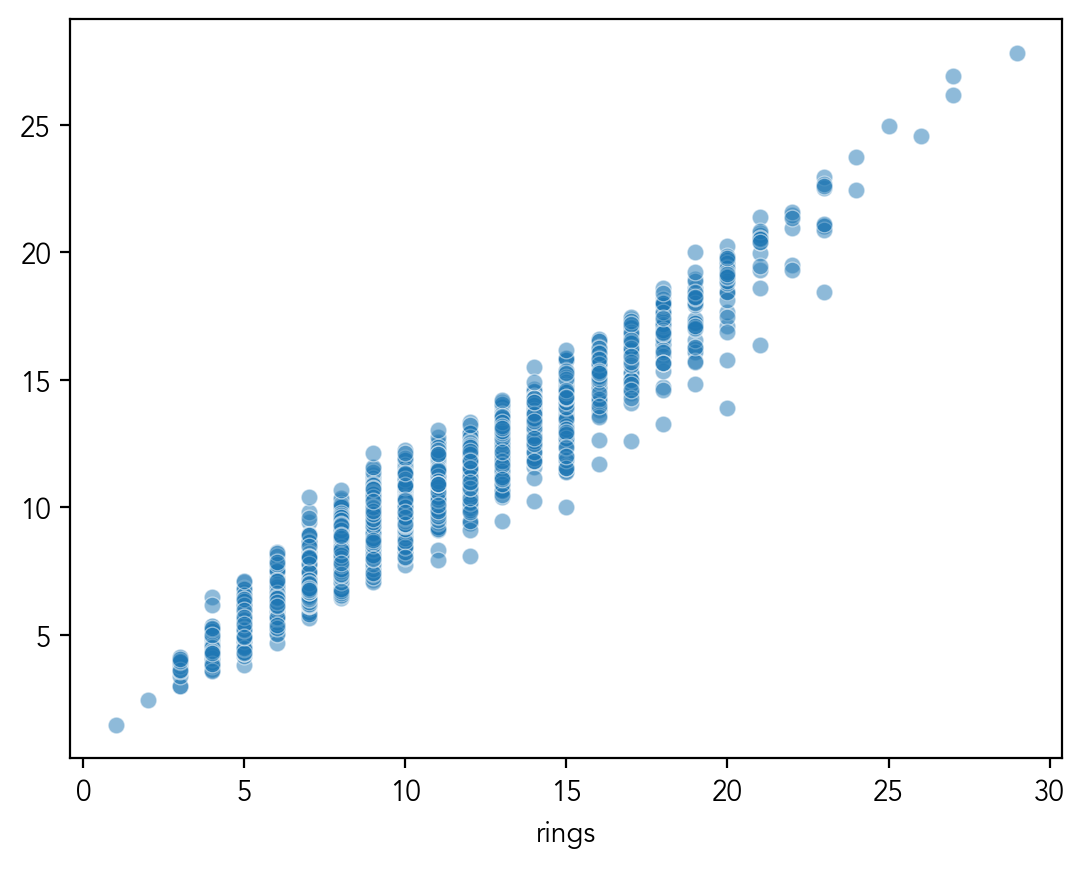

In [12]:
# Model evluations
sns.scatterplot(x = y, y = y_pred, alpha = 0.5)

In [13]:
print('MAE:', mean_absolute_error(y, y_pred))
print('MSE:', mean_squared_error(y, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y, y_pred)))
print('MSLE:', mean_squared_log_error(y, y_pred))
print('RMSLE:', np.sqrt(mean_squared_log_error(y, y_pred)))
print('R-squared:', r2_score(y, y_pred))

MAE: 0.6202393691449009
MSE: 0.7202138748430992
RMSE: 0.8486541550261208
MSLE: 0.006194402304964025
RMSLE: 0.07870452531439362
R-squared: 0.9307005377736117


In [14]:
# Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [15]:
np.shape(shap_values.values)

(4177, 10)

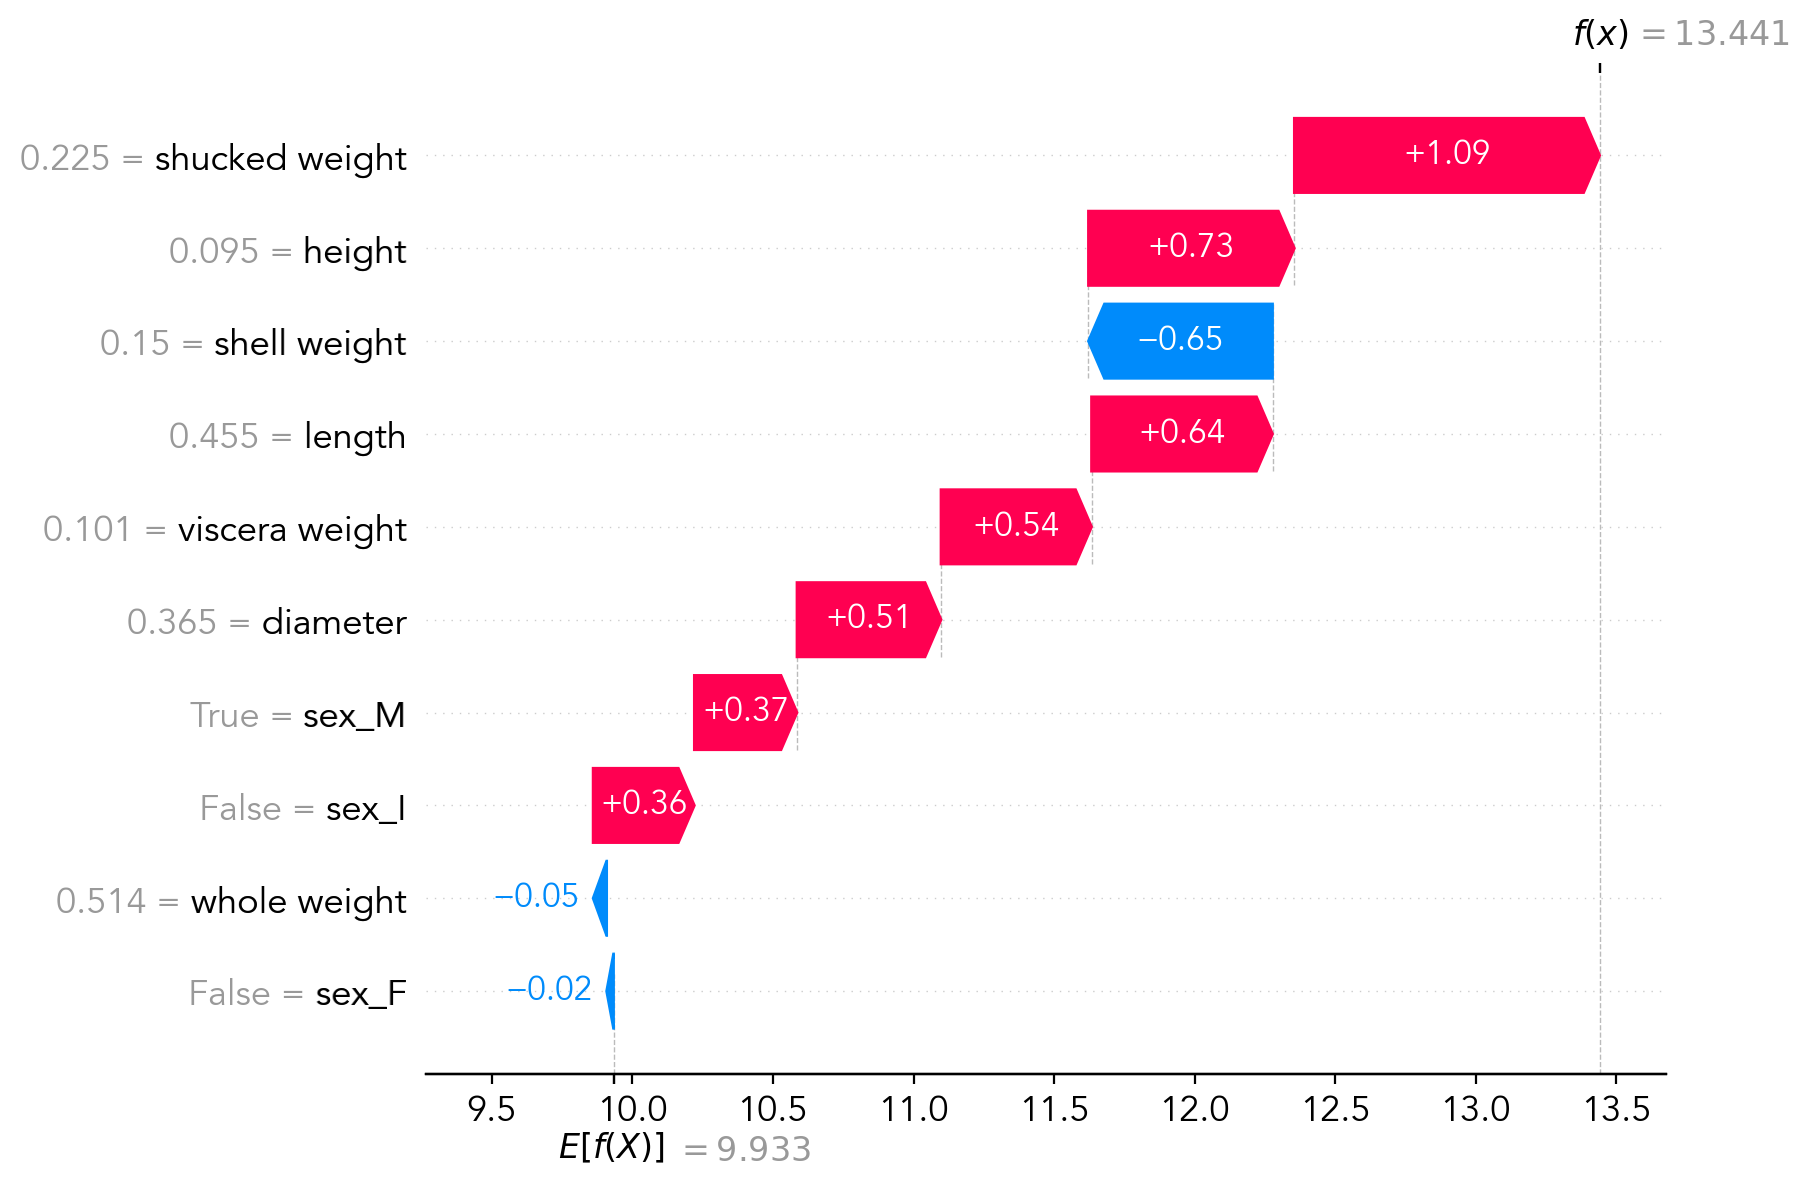

In [16]:
# Waterfall plot for the first observation
shap.plots.waterfall(shap_values[0])

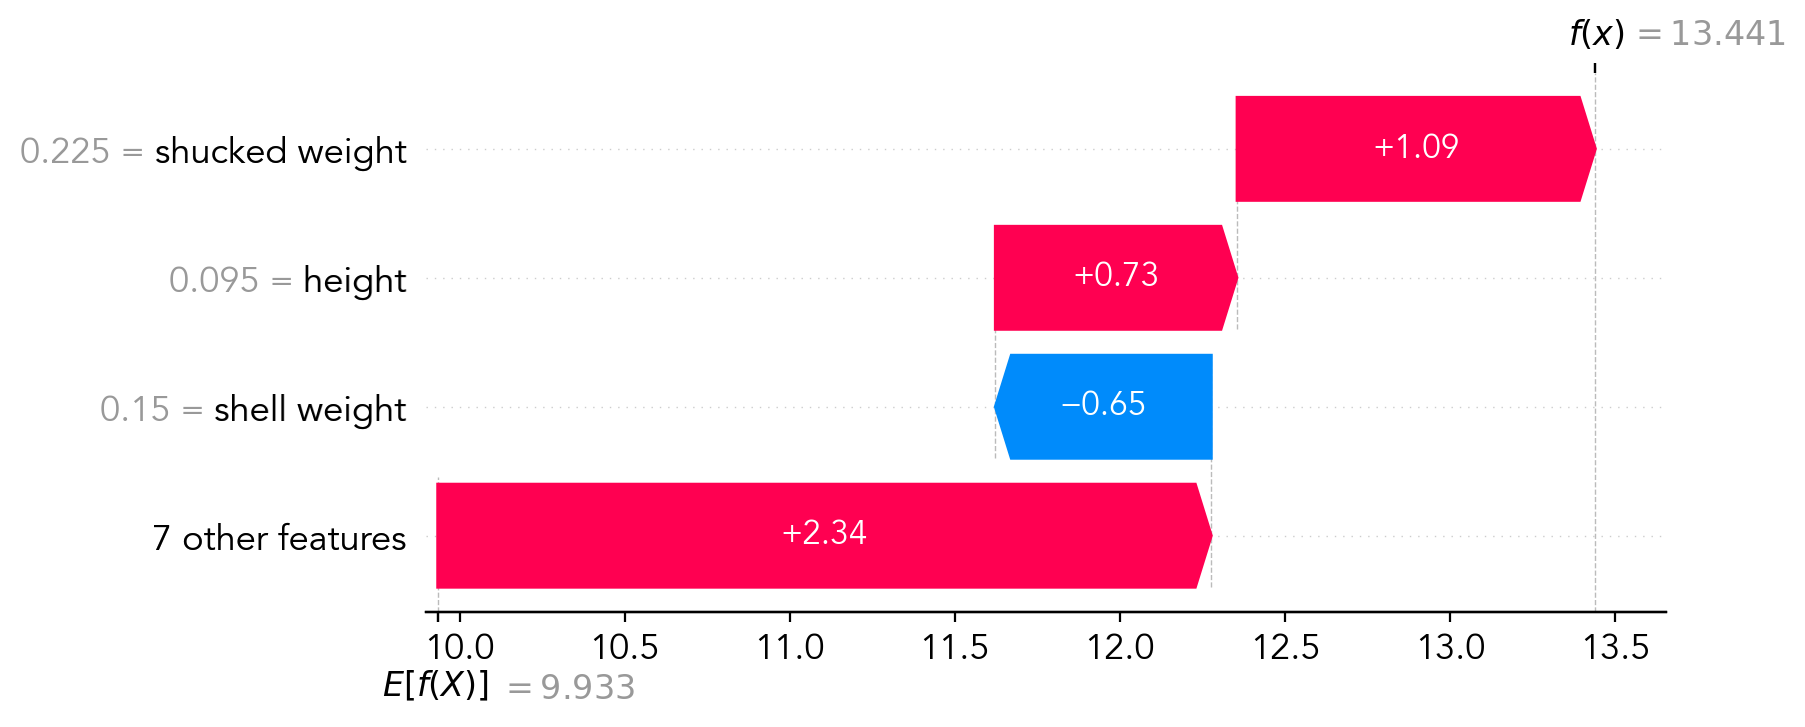

In [17]:
shap.plots.waterfall(shap_values[0], max_display=4)

In [18]:
# Force plot
shap.plots.force(shap_values[0])

In [19]:
shap.plots.force(shap_values[0:100])

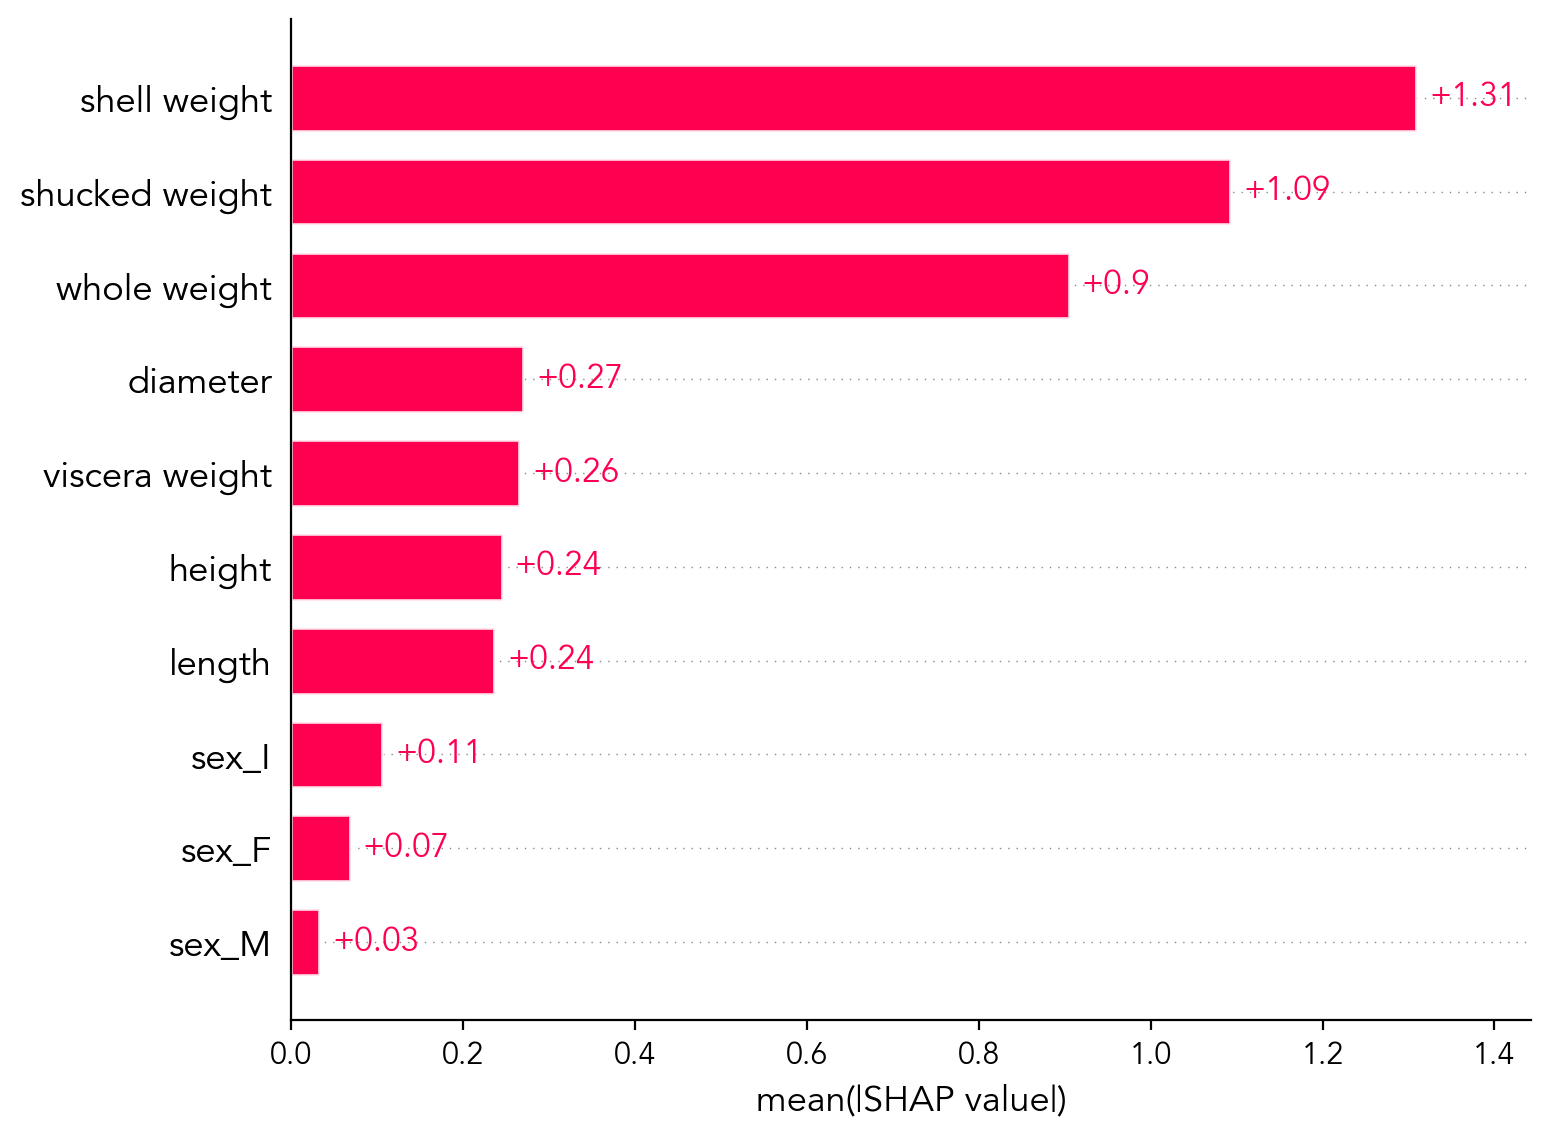

In [20]:
# Absolute Mean SHAP values
shap.plots.bar(shap_values)

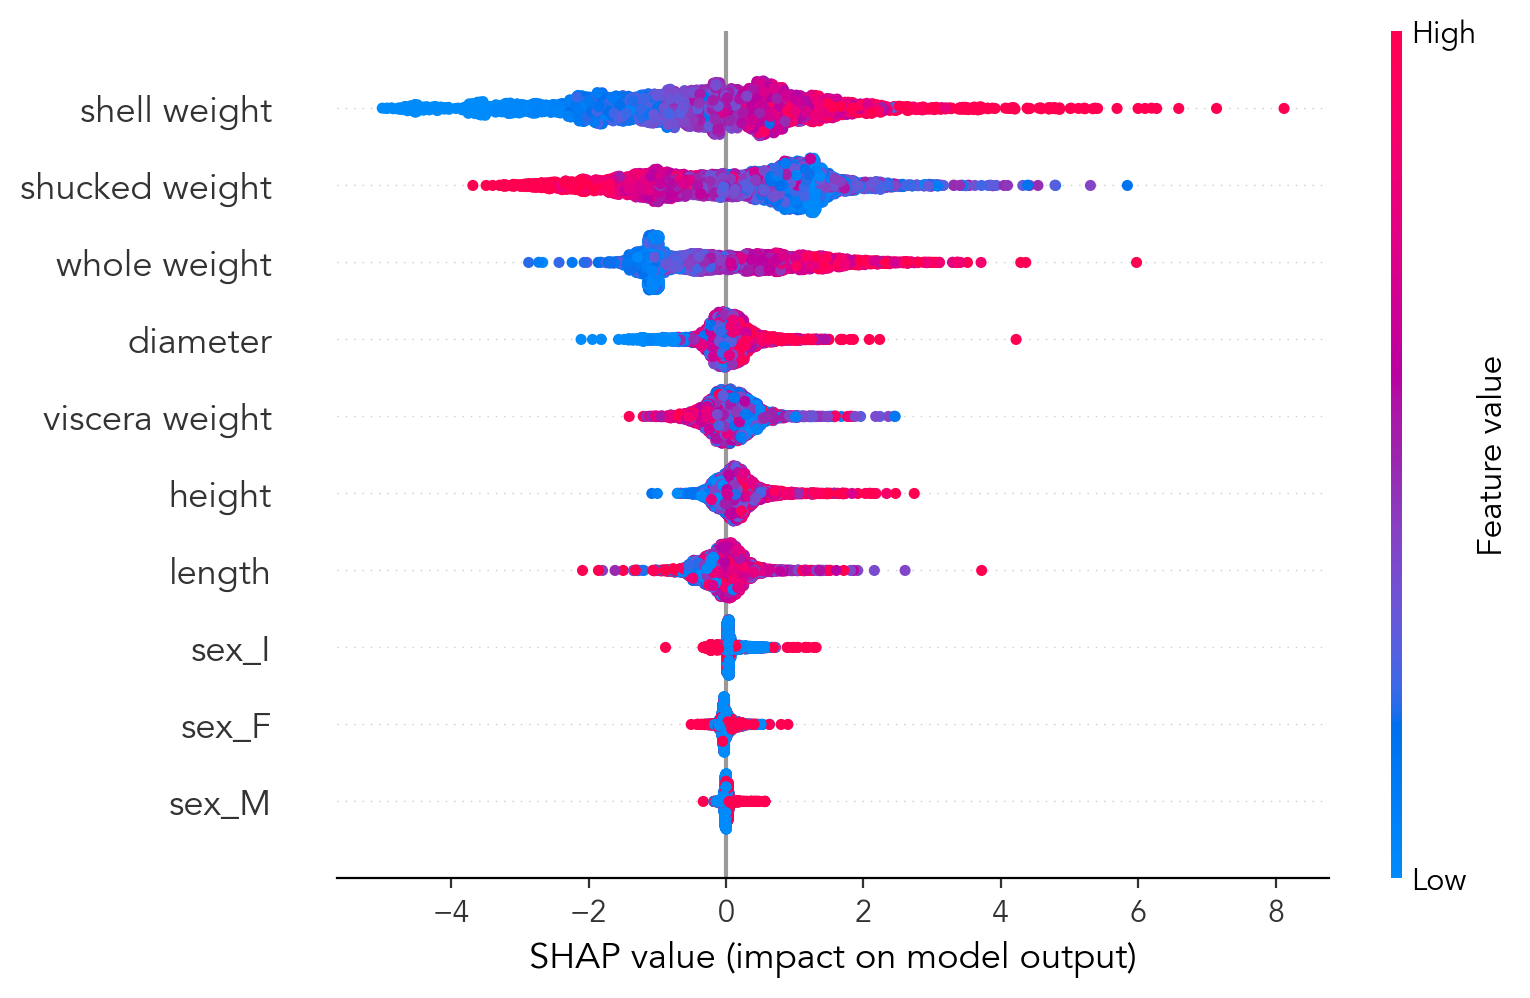

In [21]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

In [22]:
# Violin plot
# shap.plots.violin(shap_values)


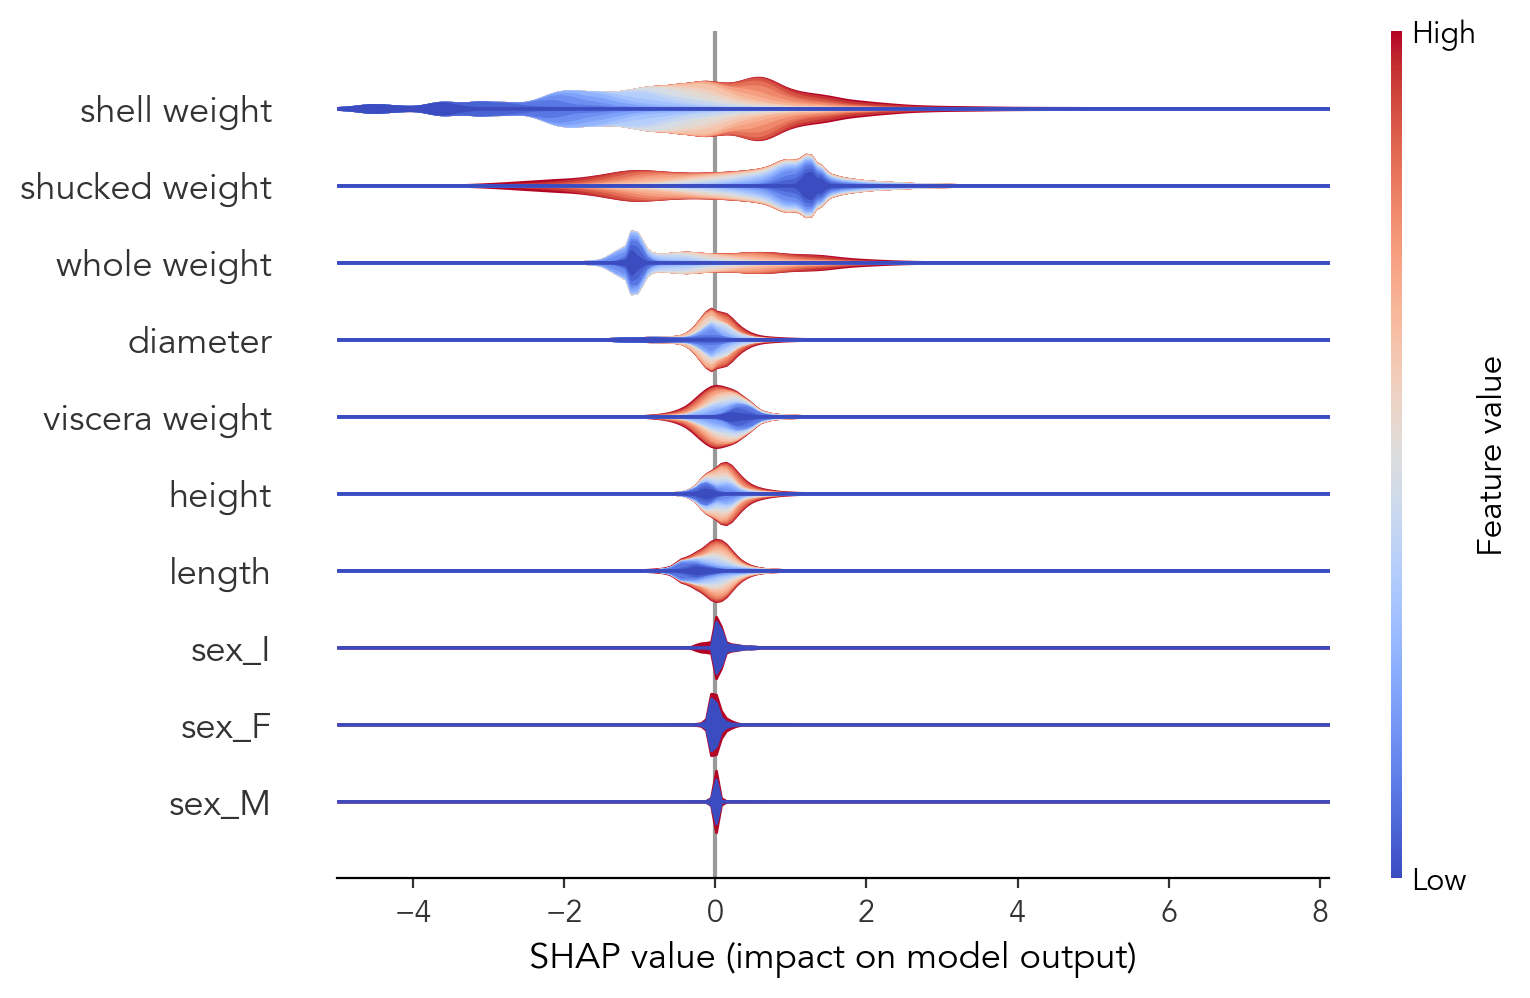

In [23]:
# Layered violine plot
shap.plots.violin(shap_values, plot_type = 'layered_violin')

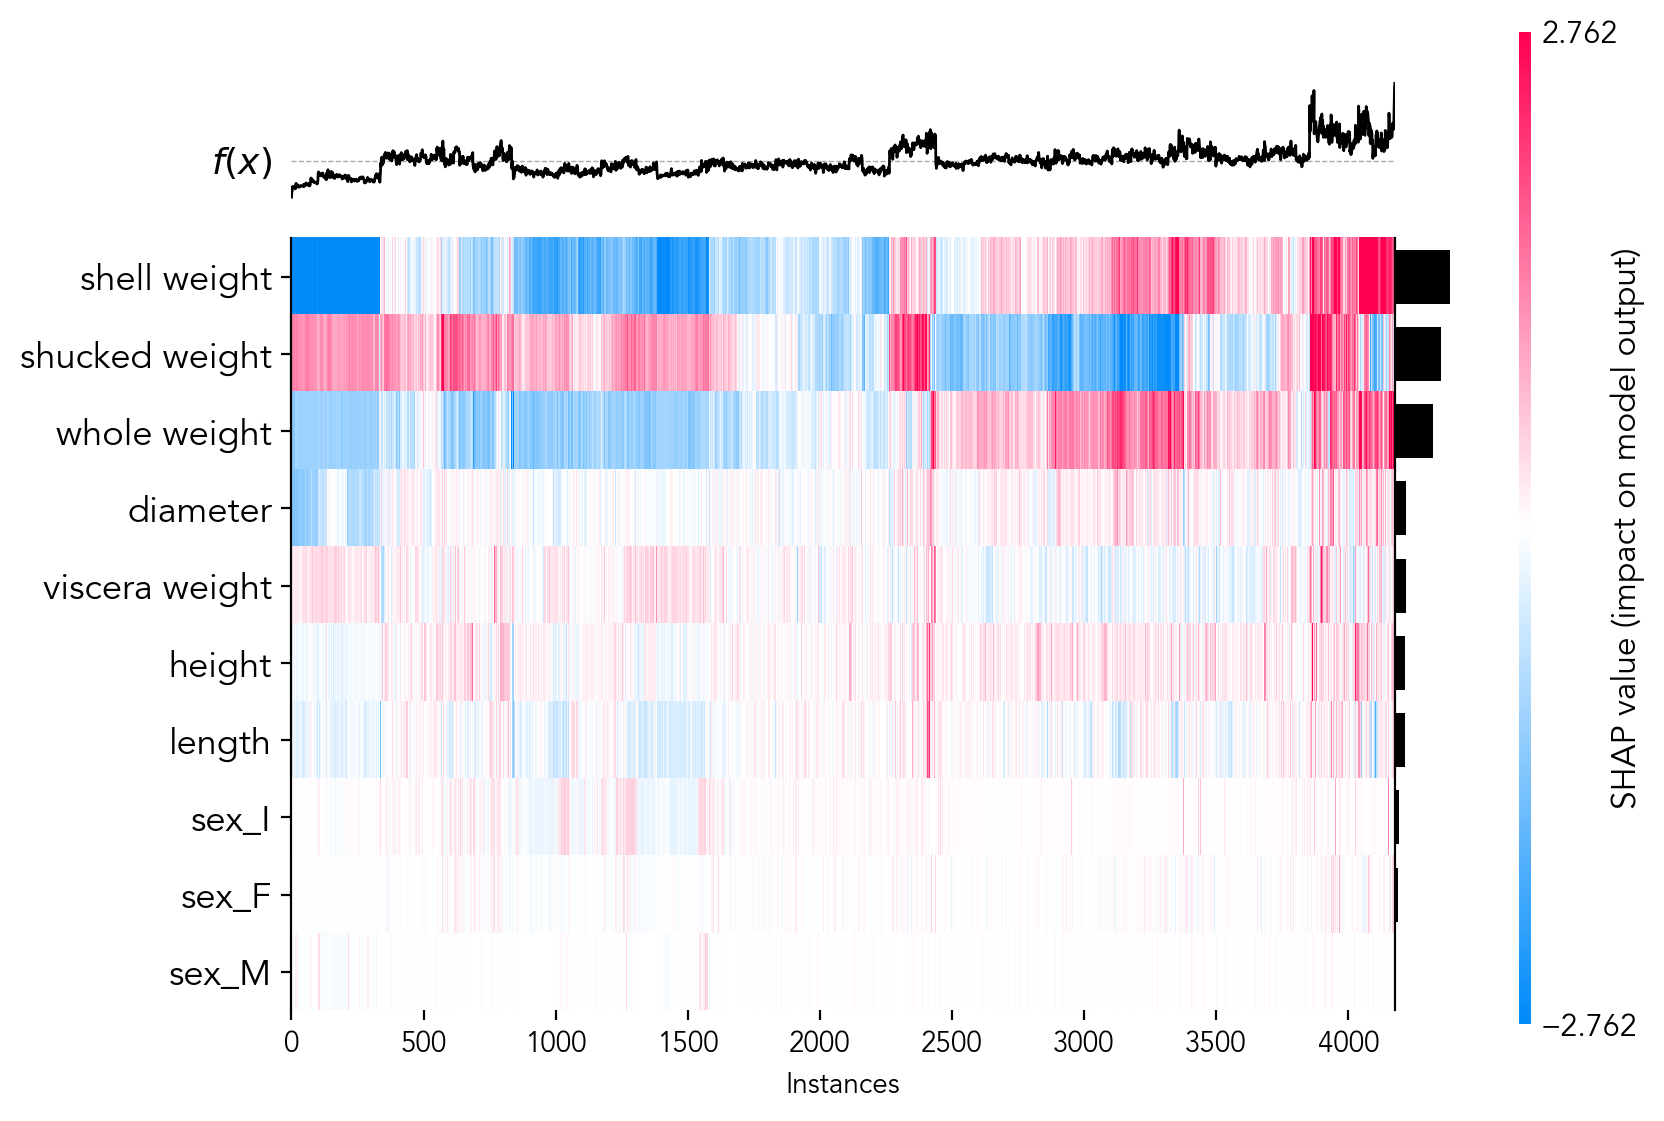

In [24]:
# Heatmap
shap.plots.heatmap(shap_values)

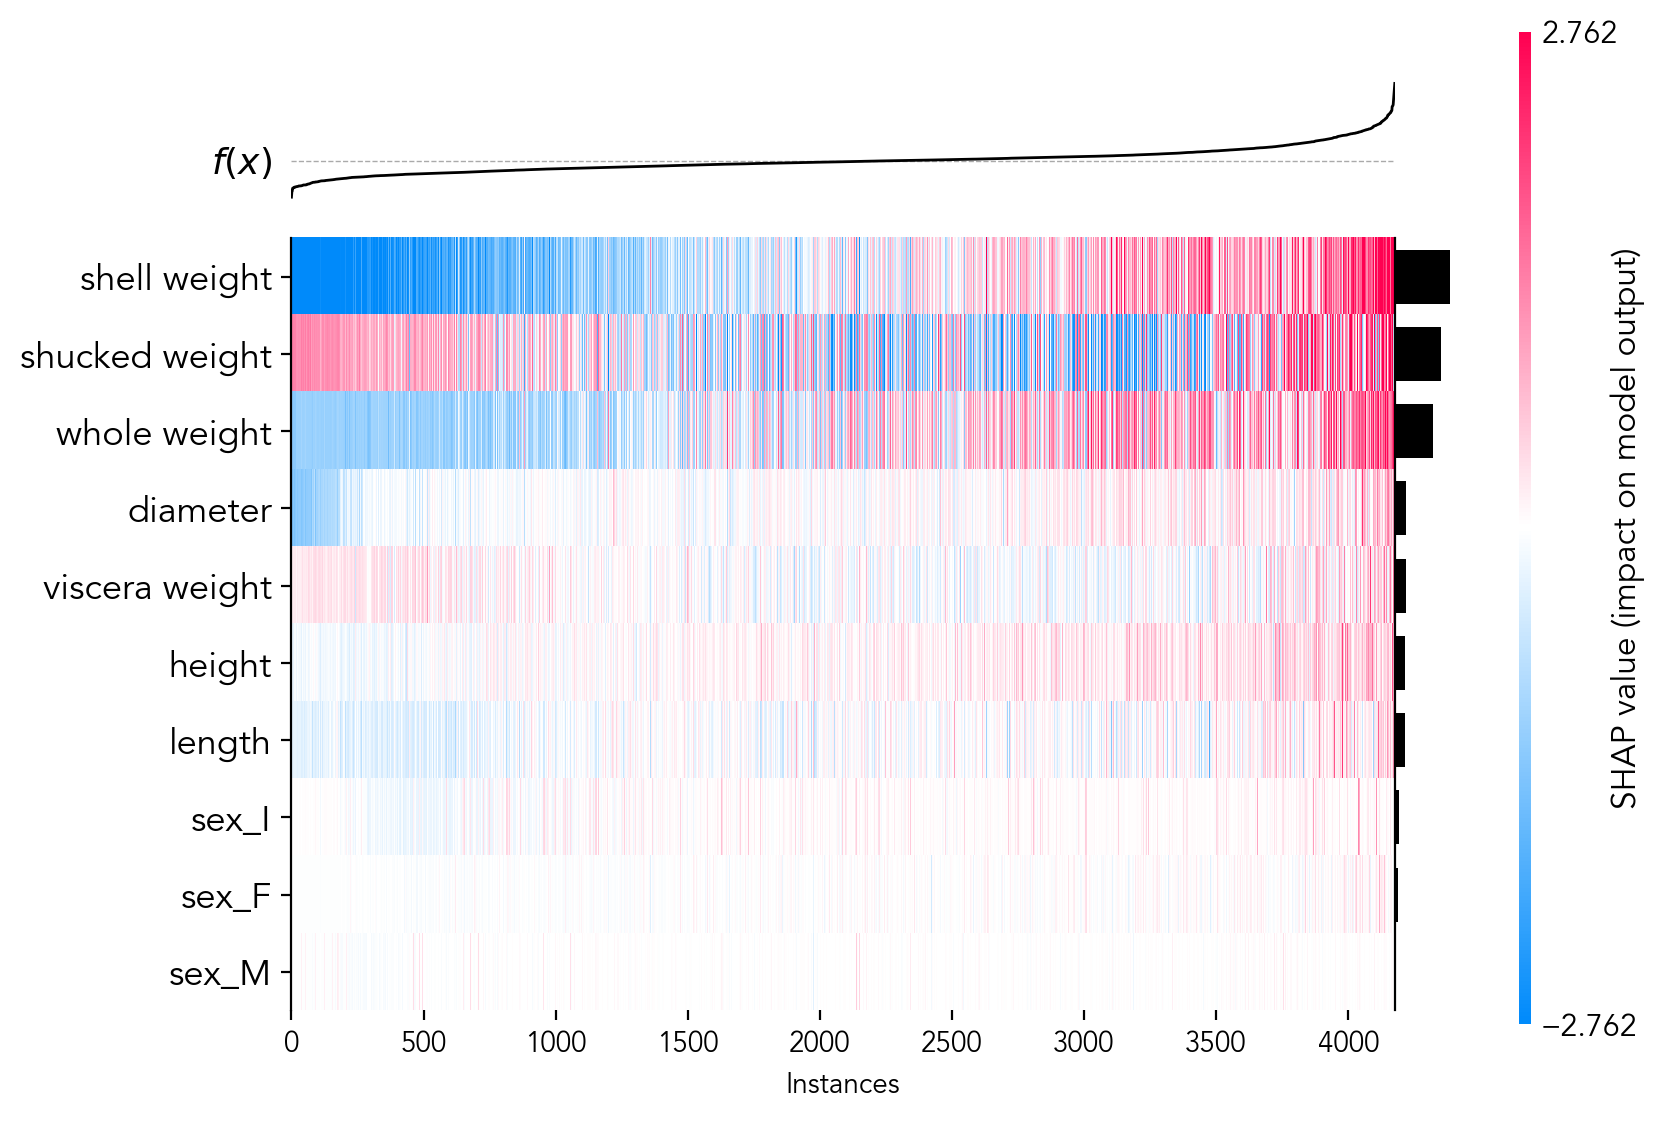

In [25]:
# Order by predictions
order = np.argsort(y_pred)
shap.plots.heatmap(shap_values, instance_order = order)

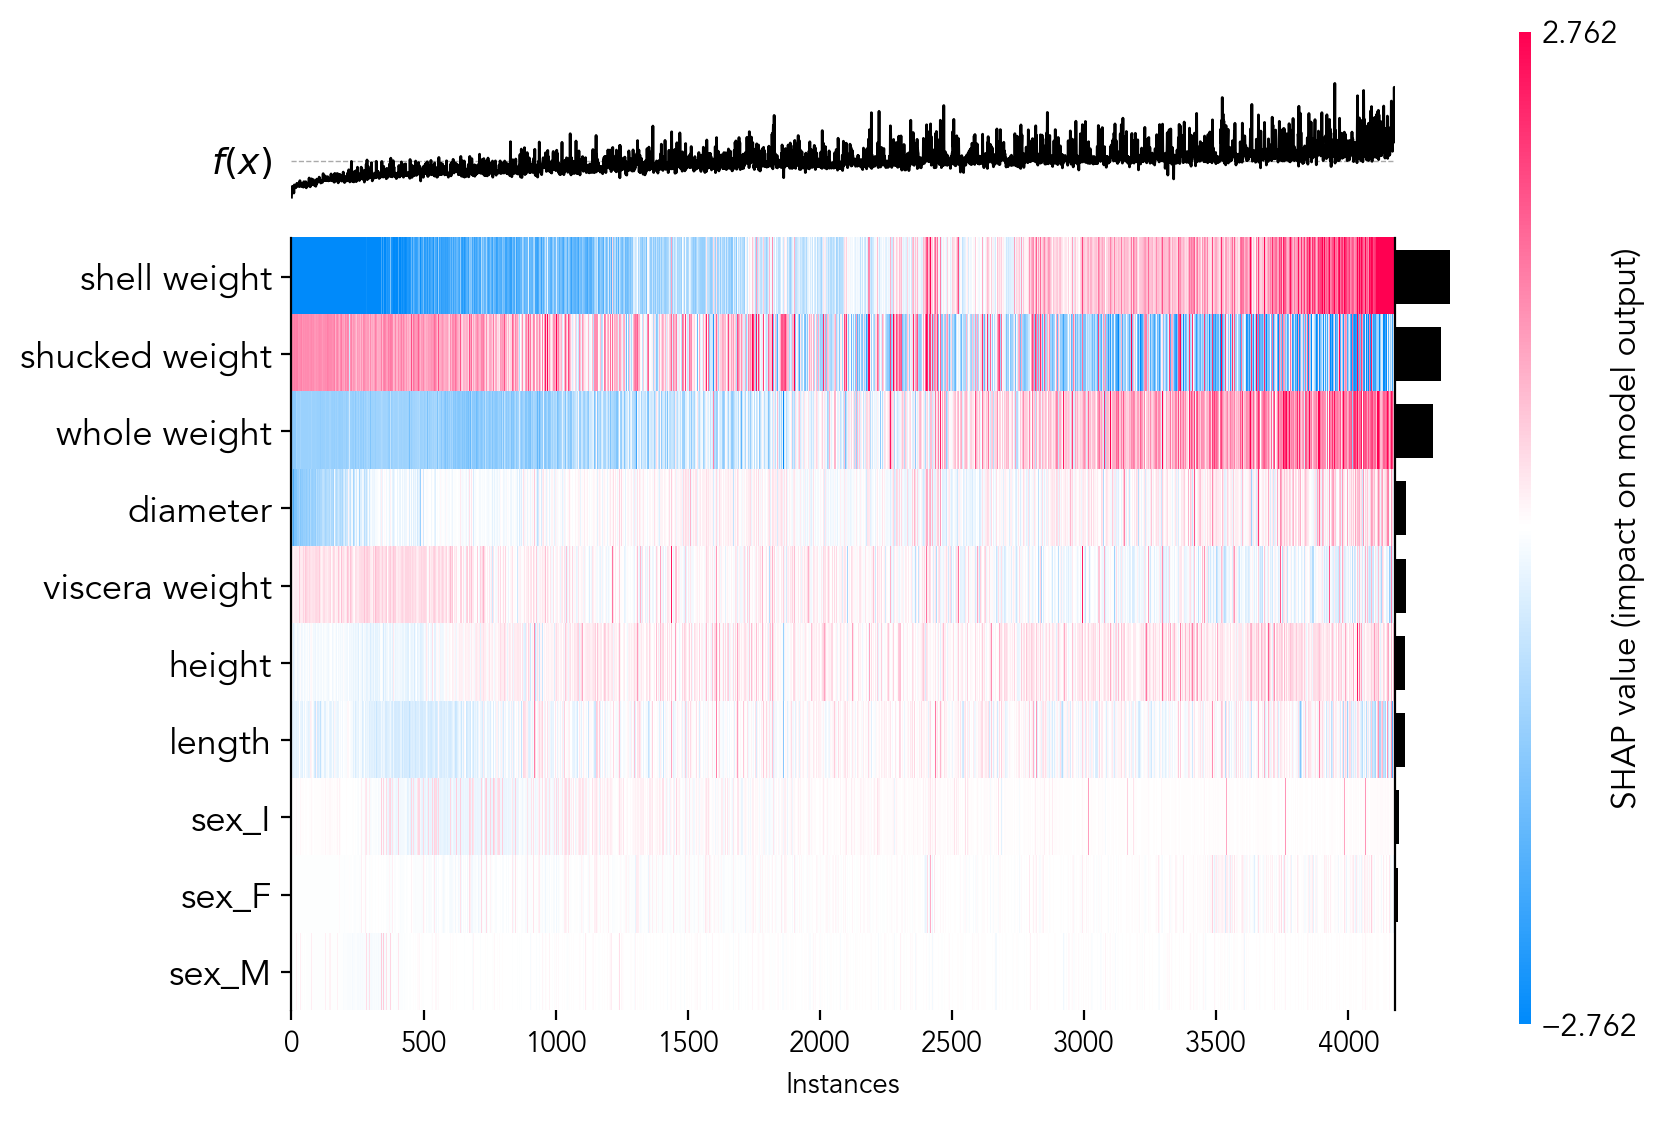

In [26]:
# Order by shell weight value
order = np.argsort(data['shell weight'])
shap.plots.heatmap(shap_values, instance_order = order)

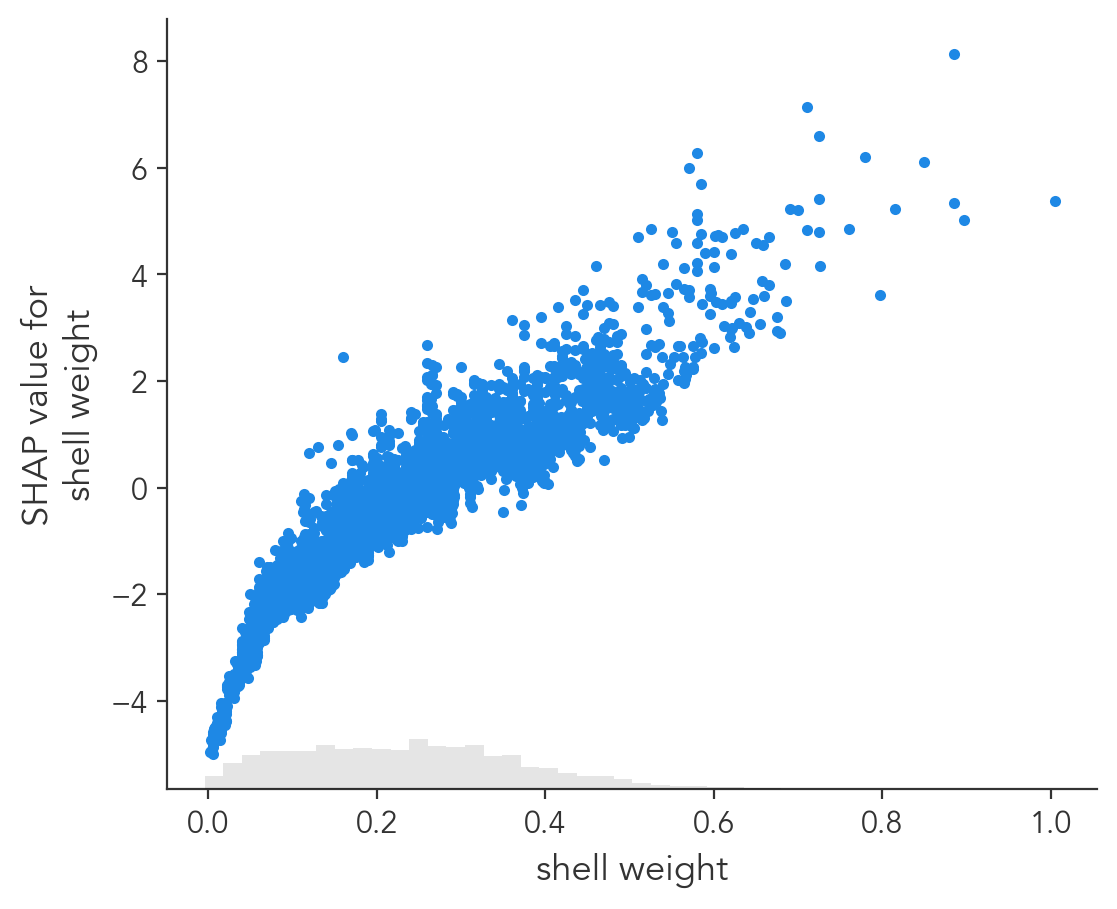

In [27]:
# Dependence plots
shap.plots.scatter(shap_values[:, 'shell weight'])

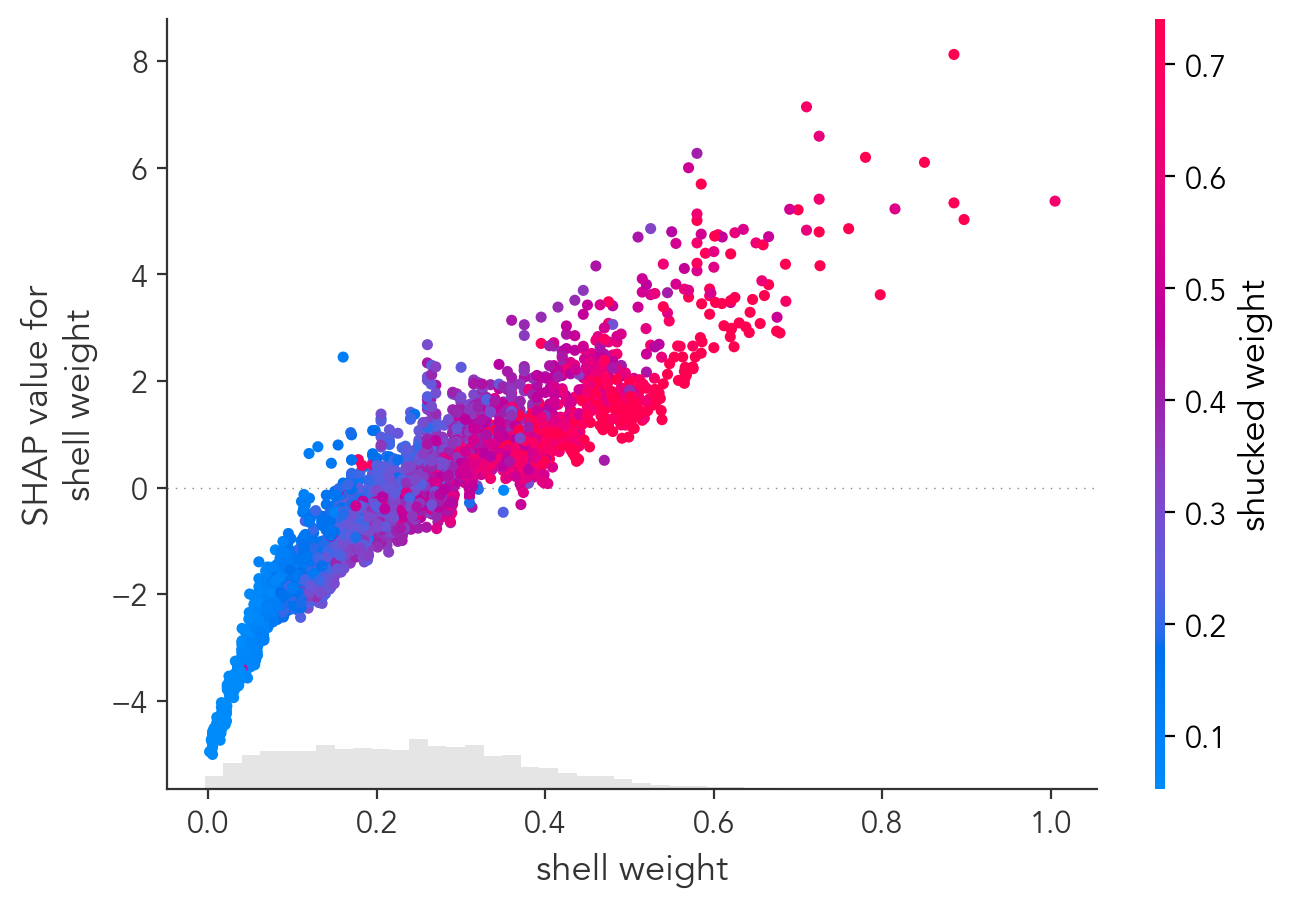

In [28]:
shap.plots.scatter(shap_values[:, 'shell weight'],
                   color = shap_values[:, 'shucked weight'])

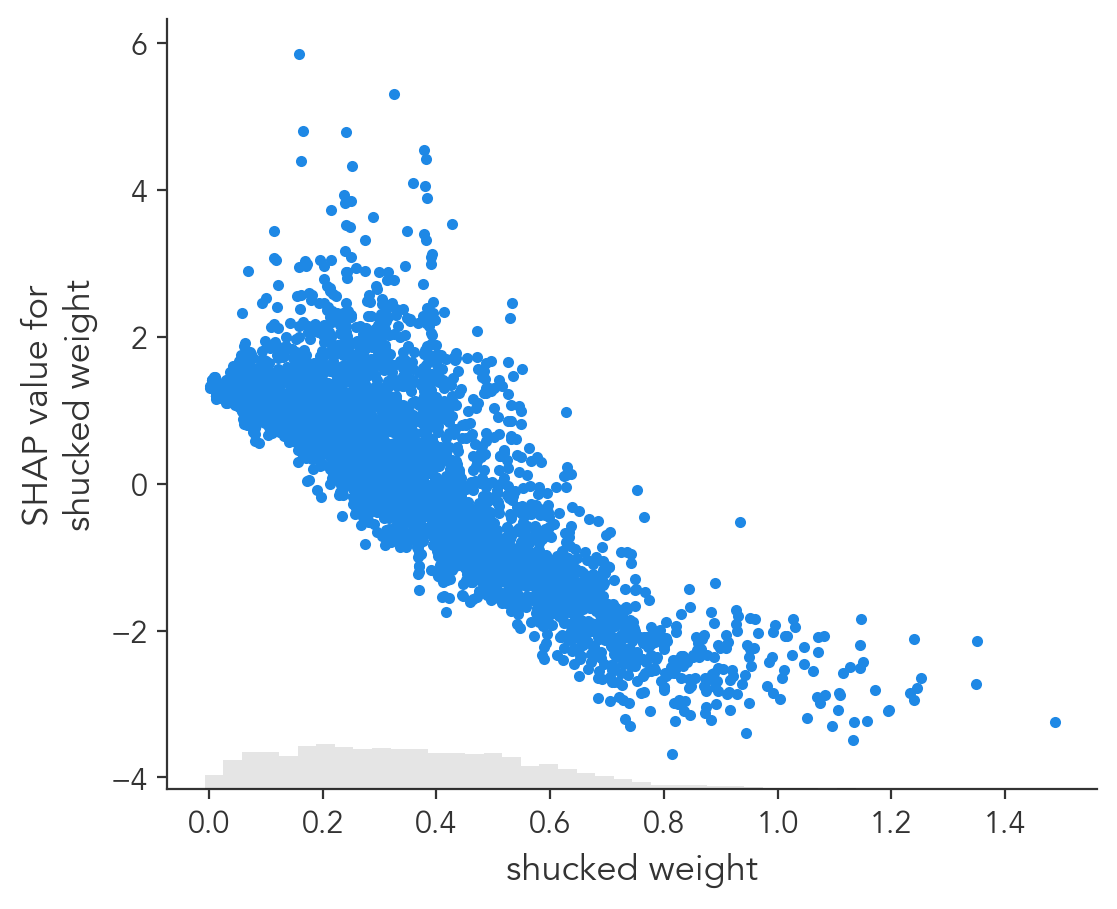

In [29]:
shap.plots.scatter(shap_values[:, 'shucked weight'])

In [30]:
shap_values

.values =
array([[ 6.43719554e-01,  5.12253046e-01,  7.32342601e-01, ...,
        -2.44900435e-02,  3.59986544e-01,  3.65143597e-01],
       [-4.25514728e-01, -4.93034780e-01, -3.12807053e-01, ...,
        -5.29507734e-02,  2.93412179e-01,  5.37105203e-02],
       [-1.74852967e-01,  7.91739905e-04,  9.07720923e-02, ...,
         1.26399130e-01,  1.68999076e-01,  1.45553472e-02],
       ...,
       [ 1.04510695e-01,  1.62028223e-01,  9.14546907e-01, ...,
         2.01492198e-02,  3.57391685e-02, -4.61242124e-02],
       [-3.28496695e-01,  1.62908241e-01,  5.24389930e-02, ...,
         1.94085948e-02,  3.52346450e-02,  3.69057991e-02],
       [-5.04229404e-02,  3.87722969e-01,  1.89526290e-01, ...,
         1.02388039e-01,  4.63808924e-02,  2.83728391e-02]], dtype=float32)

.base_values =
array([9.932957, 9.932957, 9.932957, ..., 9.932957, 9.932957, 9.932957],
      dtype=float32)

.data =
array([[0.455, 0.365, 0.095, ..., False, False, True],
       [0.35, 0.265, 0.09, ..., False, False

In [31]:
np.shape(shap_values.values)

(4177, 10)

<Axes: >

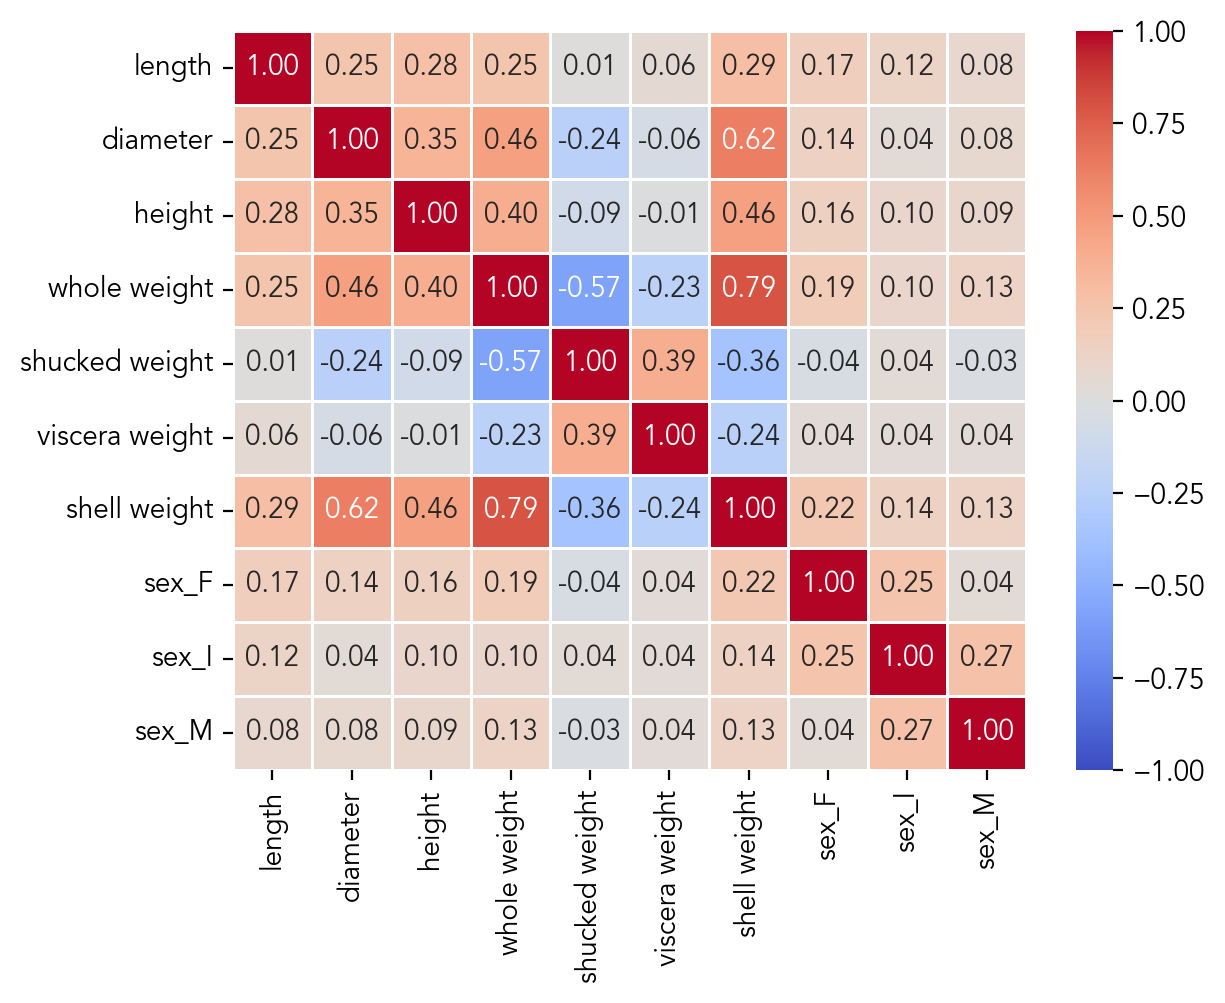

In [32]:
# SHAP correlation plot
corr_shap = pd.DataFrame(shap_values.values, columns = X.columns).corr()
sns.heatmap(corr_shap, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, center=0, vmin=-1, vmax=1)


Text(0.5, 1.0, 'SHAP Correlation Matrix')

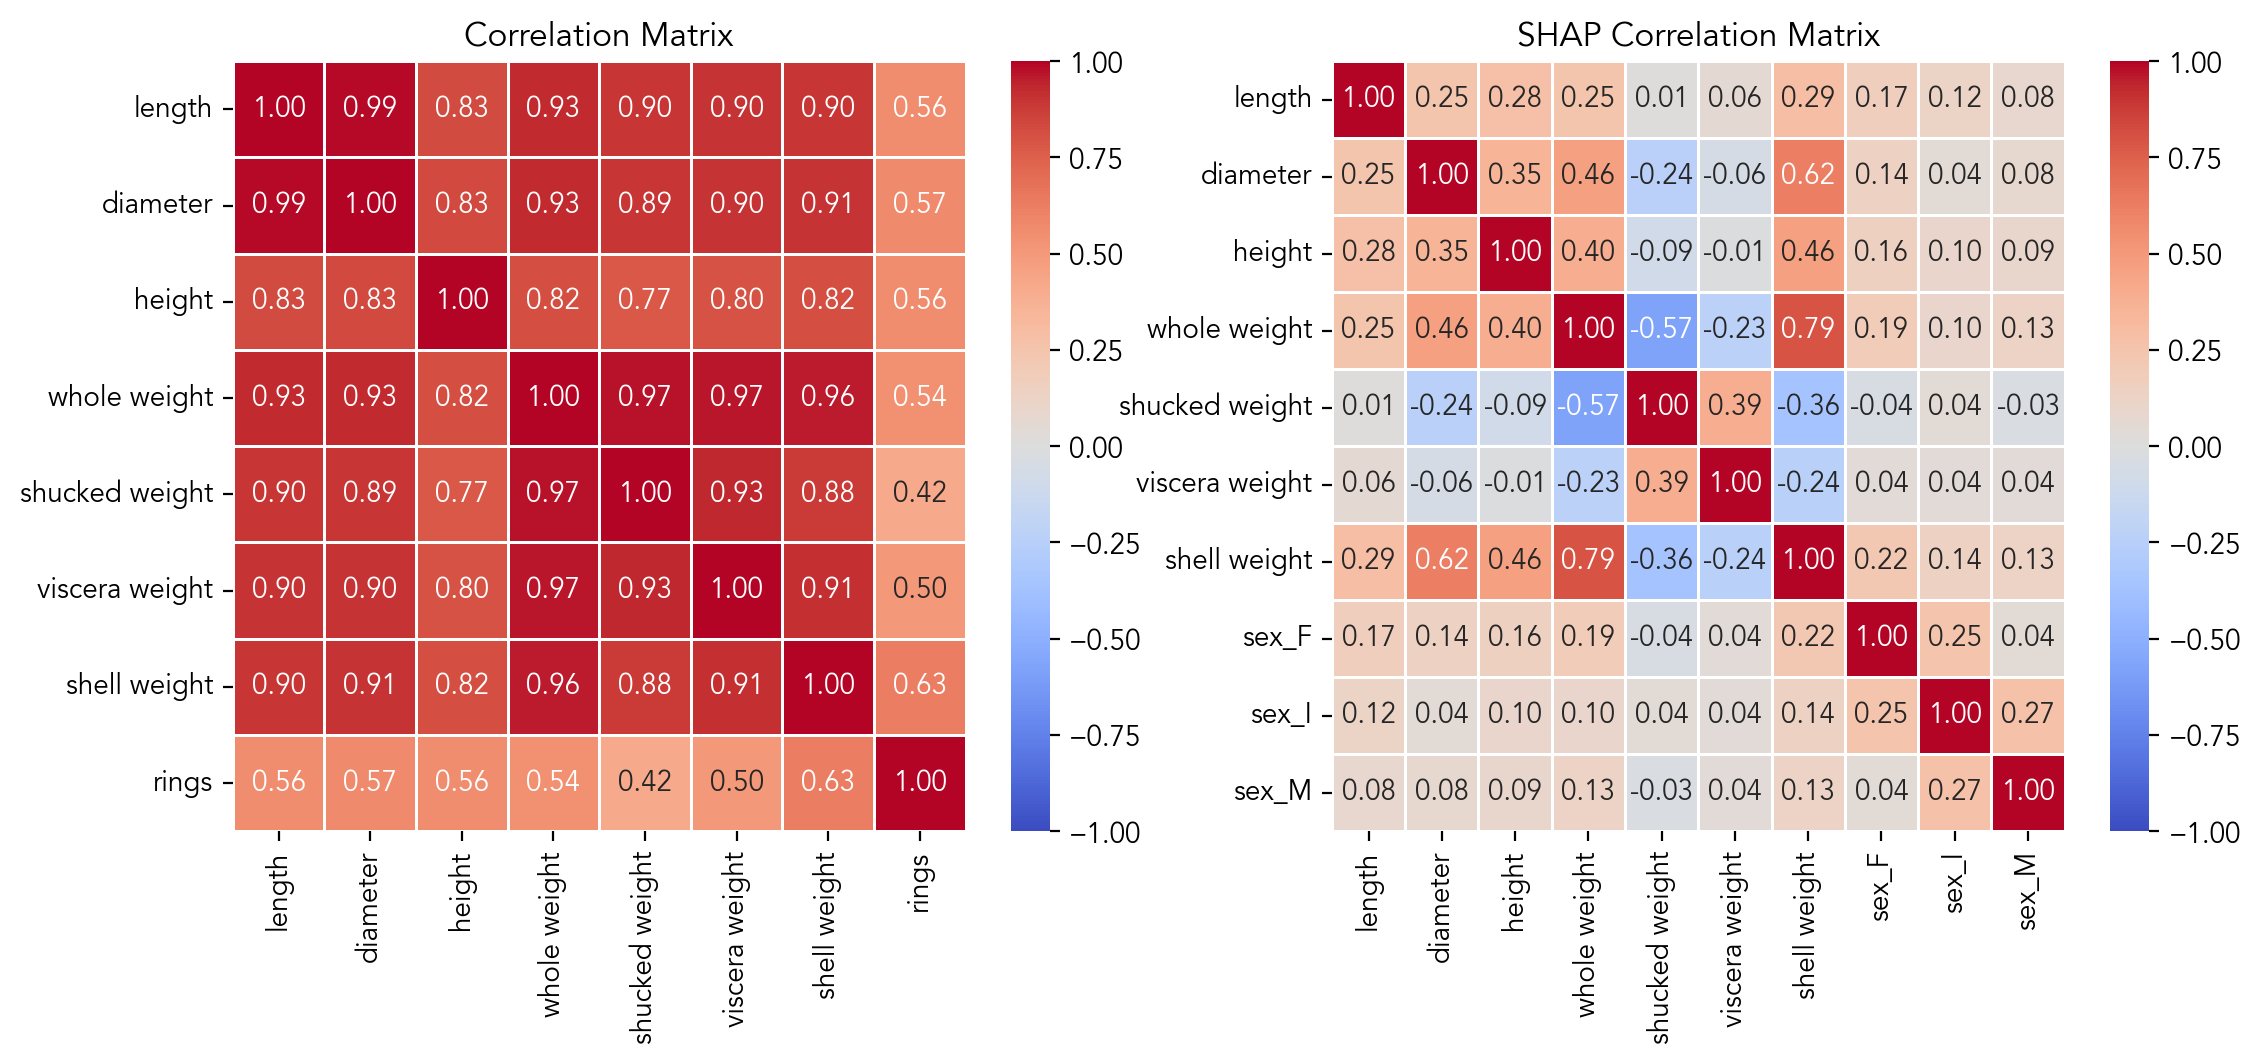

In [33]:
f, ax = plt.subplots(1, 2, figsize = (13, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, center=0, vmin=-1, vmax=1, ax = ax[0])
ax[0].set_title('Correlation Matrix')
sns.heatmap(corr_shap, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, center=0, vmin=-1, vmax=1, ax = ax[1])
ax[1].set_title('SHAP Correlation Matrix')